In [2]:
import pandas as pd
import numpy as np
import multiprocessing
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('../data/tweets&sentiment&absoluteprices.csv')

## Feature preprocessing

### Drop features

In this step, features not useful for modelling are discarded. Such features are:
* source
* text
* created_at
* id_str
* hashtag
* mention
* neg_sentiment
* neu_sentiment
* pos_sentiment
* created_date
* created_time
* passed_closing
* market_date

In [4]:
# drop review_no, product_id and review_date
df = df.drop(columns=['source', 'text', 'created_at', 'id_str', 'hashtag', 'mention', 
                      'neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'created_date',
                      'created_time', 'passed_closing'
                     ], errors='ignore')

In [5]:
df.columns

Index(['cleaned_text', 'retweet_count', 'favorite_count', 'is_retweet',
       'hashtag_count', 'mention_count', 'word_count', 'char_count',
       'word_density', 'punctuation_freq', 'upper_case_freq',
       'compound_sentiment', 'market_date', '^GSPC', '^IXIC', 'VGT'],
      dtype='object')

### Type casting

In [6]:
df.dtypes

cleaned_text           object
retweet_count           int64
favorite_count          int64
is_retweet             object
hashtag_count           int64
mention_count           int64
word_count              int64
char_count              int64
word_density          float64
punctuation_freq      float64
upper_case_freq       float64
compound_sentiment    float64
market_date            object
^GSPC                 float64
^IXIC                 float64
VGT                   float64
dtype: object

In [7]:
# change is_tweet from boolean to binary
df['is_retweet'] = df['is_retweet'].replace({True:1, False:0})

### Drop NA values

In [8]:
df.isna().sum()

cleaned_text          1192
retweet_count            0
favorite_count           0
is_retweet              58
hashtag_count            0
mention_count            0
word_count               0
char_count               0
word_density           928
punctuation_freq       928
upper_case_freq        928
compound_sentiment       0
market_date              0
^GSPC                    0
^IXIC                    0
VGT                      0
dtype: int64

In [9]:
df = df.dropna(how='any')
df = df.reset_index().drop(columns=['index'])

In [10]:
df.head()

,cleaned_text,retweet_count,favorite_count,is_retweet,hashtag_count,mention_count,word_count,char_count,word_density,punctuation_freq,upper_case_freq,compound_sentiment,market_date,^GSPC,^IXIC,VGT
0,thank,19616,65721,0.0,0,1,5,28,5.600000,0.400000,0.000000,0.4199,2020-10-01,3380.800049,11326.509766,315.329987
1,big news maine court side rnc uphold ban ballo...,29393,0,1.0,0,0,24,138,5.750000,0.291667,0.166667,0.0000,2020-10-01,3380.800049,11326.509766,315.329987
2,thank paul,15992,63294,0.0,0,0,4,16,4.000000,0.250000,0.000000,0.4199,2020-10-01,3380.800049,11326.509766,315.329987
3,defective ballot new york want replace happen ...,51445,190750,0.0,0,0,42,199,4.738095,0.119048,0.857143,-0.7988,2020-10-01,3380.800049,11326.509766,315.329987
4,half years secure americas border rebuild awes...,18885,70838,0.0,1,0,43,239,5.558140,0.093023,0.116279,-0.1260,2020-10-01,3380.800049,11326.509766,315.329987


### Correlation plot
From the correlation plot it can be seen that the meta text features have little correlation with the target variables

In [13]:
from string import ascii_letters

TypeError: 'float' object cannot be interpreted as an integer

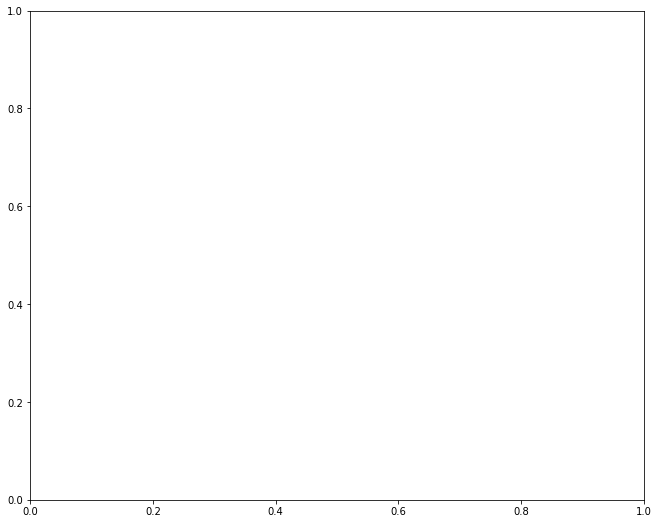

In [14]:
# sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

plt.show()

### Normalise features
Normalisation is essential for deep-learning/NN-related tasks. MinMax Scaler is chosen in this case to rescale the numeric inputs.

In [131]:
from sklearn.preprocessing import MinMaxScaler

In [132]:
# obtain a list of numeric columns
numeric_cols = list(df.columns)

# remove text and output columns
numeric_cols.remove('cleaned_text')
numeric_cols.remove('^GSPC')
numeric_cols.remove('^IXIC')
numeric_cols.remove('VGT')

In [133]:
# scale the features
scaler = MinMaxScaler() 
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

### Word embedding
Word2Vec is the chosen text embedding method for several reasons:
* The mapping between the target word to its context word implicitly embeds the sub-linear relationship into the vector space of words, so that relationships like “king:man as queen:woman” can be infered by word vectors.
* It is less computationally expensive than deep language models such as GloVe, BERT, ElMo. BERT + transfer learning with BiLSTM was initially chosen for this problem but due to the relatively large dataset and limited computational power, training was extremely slow.

#### Further process text for Word2Vec

In [134]:
import nltk

In [135]:
def process_text_w2v(paragraph):    
    result = list()
    for line in nltk.sent_tokenize(paragraph):
        tokenizer = nltk.RegexpTokenizer(r"\w+")
        tokens = [token for token in tokenizer.tokenize(line)]
        result.append(tokens) 
    return result

In [136]:
df['cleaned_text_w2v'] = df['cleaned_text'].apply(lambda x: process_text_w2v(x))

In [137]:
# compile all sentences together to compose the corpus for later usage.
sentences = [sent for x in df['cleaned_text_w2v'].values.tolist() for sent in x]

#### Set parameters for word2vec model
`min_count` is set to 1 since we would like to obtain the embeddings of all words in our vocabulary for subsequent modelling to work. Normally, `min_count` is set to a larger value.

In [138]:
import gensim
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

In [139]:
w2v_model = Word2Vec(min_count=1, 
                     window=3,
                     size=64,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count())

#### Building the Vocabulary Table
Digest all the words and filter out the unique words, and doing some basic counts on them.

In [140]:
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.07 mins


### Train Word2Vec

In [141]:
start_time = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - start_time) / 60, 2)))

Time to train the model: 0.23 mins


In [142]:
w2v_model.save('../model/word2vec/word2vec.model')

In [143]:
w2v_model.init_sims(replace=True)

#### Generate Word2Vec vectors
generate and write the word embedding vectors to directory

In [144]:
# # load the model from the model file
# w2v_model = Word2Vec.load('../model/word2vec.model')

In [145]:
# Store the vectors in a csv file
with open('../model/word2vec/word2vec.csv', 'w+') as word2vec_file:
    
    for index, row in df.iterrows():
        model_vector = (np.mean([w2v_model[token] for token in row['cleaned_text_w2v'][0]], axis=0)).tolist()
        
        if index == 0:
            header = ",".join(str(ele) for ele in range(64))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(64)])
        
        word2vec_file.write(line1)
        word2vec_file.write('\n')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


#### Concatenate the word embeddings with other features in the datasets

In [146]:
w2v_embeddings = pd.read_csv('../model/word2vec/word2vec.csv')

In [147]:
df = pd.concat([df, w2v_embeddings], axis=1)

In [148]:
df.head()

,cleaned_text,retweet_count,favorite_count,is_retweet,hashtag_count,mention_count,word_count,char_count,word_density,punctuation_freq,...,54,55,56,57,58,59,60,61,62,63
0,thank,0.053084,0.074713,0.0,0.0,0.1,0.057971,0.085174,0.328571,0.240000,...,0.065594,0.094567,0.022625,0.031416,-0.211155,0.256162,-0.076439,0.046196,-0.178672,0.282274
1,big news maine court side rnc uphold ban ballo...,0.079542,0.000000,1.0,0.0,0.0,0.333333,0.432177,0.339286,0.175000,...,0.016894,0.028469,-0.032220,0.027841,-0.131000,-0.026378,-0.019021,0.125694,-0.159512,0.051435
2,thank paul,0.043277,0.071954,0.0,0.0,0.0,0.043478,0.047319,0.214286,0.150000,...,-0.025543,0.134922,0.037013,-0.022119,-0.081507,0.268150,-0.066681,0.082602,-0.176282,0.178487
3,defective ballot new york want replace happen ...,0.139217,0.216848,0.0,0.0,0.0,0.594203,0.624606,0.267007,0.071429,...,-0.006196,0.014436,-0.001041,-0.010833,-0.074154,0.013568,-0.091835,0.090702,-0.144243,0.002622
4,half years secure americas border rebuild awes...,0.051105,0.080530,0.0,0.1,0.0,0.608696,0.750789,0.325581,0.055814,...,-0.001725,0.052266,-0.002023,0.012134,-0.030705,0.108762,-0.015056,-0.030167,-0.169160,-0.006276


#### Drop `cleaned_text` and `cleaned_text_w2v`

In [149]:
df = df.drop(columns=['cleaned_text', 'cleaned_text_w2v'], errors='ignore')

### Train test split

In [150]:
from sklearn.model_selection import train_test_split

In [151]:
y_GSPC = df['^GSPC']
y_IXIC = df['^IXIC']
y_VGT = df['VGT']
X = df.drop(columns=['^GSPC', '^IXIC', 'VGT'], errors='ignore')

In [152]:
# train is 75% of the entire data set
train_ratio = 0.75

#### GSPC

In [153]:
X_train_GSPC, X_test_GSPC, y_train_GSPC, y_test_GSPC = train_test_split(X, y_GSPC, test_size=1 - train_ratio, random_state=1)

#### IXIC

In [154]:
X_train_IXIC, X_test_IXIC, y_train_IXIC, y_test_IXIC = train_test_split(X, y_IXIC, test_size=1 - train_ratio, random_state=1)

#### VGT

In [155]:
X_train_VGT, X_test_VGT, y_train_VGT, y_test_VGT = train_test_split(X, y_VGT, test_size=1 - train_ratio, random_state=1)

## Modelling - XGBoost 
XGBoost is chosen to be the classification model for a few reasons:
* XGBoost is an ensemble method which helps improve machine learning results by combining and improving on the results from multiple single models.
* As compared to gradient boosting algorithms, XGBoost uses a more regularized model formalization to control over-fitting, which gives it better performance.
* XGBoost is built with the engineering goal to push the limit of computation resources for boosted tree algorithms. It utilises computational power more efficiently for faster, and production-ready training and testing, which is a good choice given the limited computation resources.

In [156]:
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import mean_squared_error

### Define baseline parameters

In [157]:
params = {'objective':'reg:linear',
          'learning_rate':0.05,
          'n_estimators':200,
          'max_depth':10,
          'min_child_weight':5,
          'gamma':0.1,
          'subsample':0.7,
          'colsample_bytree':0.7,
          'n_jobs':4,
          'random_state':1,
          'seed':1
         }

### Define error metrics

Write a custom function to calculate MAPE, mean average percentage error. MAPE expresses expresses accuracy as a percentage of the error. Because the MAPE is a percentage, it can be easier to understand than the other accuracy measure statistics e.g. RMSE. Refer to the picture below for a guide on the interpretation of MAPE values

<img src="https://www.researchgate.net/profile/Albert_Sese/publication/257812432/figure/tbl1/AS:601657310203931@1520457689632/nterpretation-of-typical-MAPE-values.png" width=300 align="left"/>

In [158]:
# define custom functions to calculate MAPE

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

### GSPC

In [159]:
# initialise an xgboost object
xgb_GSPC = xgboost.XGBModel(**params)

In [160]:
xgb_GSPC.fit(X_train_GSPC, y_train_GSPC,
             eval_set=[(X_train_GSPC, y_train_GSPC), (X_test_GSPC, y_test_GSPC)],
             eval_metric='rmse',
             verbose=50)

[0]	validation_0-rmse:2680.64	validation_1-rmse:2691.38
[50]	validation_0-rmse:299.061	validation_1-rmse:333.716
[100]	validation_0-rmse:158.623	validation_1-rmse:243.611
[150]	validation_0-rmse:127.632	validation_1-rmse:240.366
[199]	validation_0-rmse:106.144	validation_1-rmse:239.777


XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.7, gamma=0.1, importance_type='gain',
         learning_rate=0.05, max_delta_step=0, max_depth=10, min_child_weight=5,
         missing=None, n_estimators=200, n_jobs=4, nthread=None,
         objective='reg:linear', random_state=1, reg_alpha=0, reg_lambda=1,
         scale_pos_weight=1, seed=1, silent=True, subsample=0.7)

In [161]:
evals_result_GSPC = xgb_GSPC.evals_result()
evals_result_GSPC

{'validation_0': {'rmse': [2680.637451,
   2548.304199,
   2422.600342,
   2303.128418,
   2189.835449,
   2082.210693,
   1980.74353,
   1884.511108,
   1792.992188,
   1705.516968,
   1622.517456,
   1543.719971,
   1468.847412,
   1398.044434,
   1331.250488,
   1267.366455,
   1206.799194,
   1149.467773,
   1094.886719,
   1043.619995,
   994.718994,
   948.751404,
   905.235413,
   863.632141,
   824.542358,
   787.513245,
   752.437866,
   719.278503,
   688.004089,
   657.641479,
   629.471741,
   602.390442,
   576.798706,
   552.847778,
   529.6698,
   507.835754,
   487.660156,
   468.216492,
   449.838074,
   432.541077,
   416.217255,
   401.305695,
   386.694153,
   372.996948,
   360.509338,
   348.831848,
   337.772064,
   326.918091,
   317.093903,
   308.099854,
   299.06073,
   290.655762,
   283.426758,
   275.712372,
   268.704498,
   262.381195,
   256.891357,
   251.032883,
   245.553116,
   240.269028,
   235.209305,
   230.466003,
   226.214096,
   222.204453,


In [162]:
xgb_GSPC.feature_importances_

array([0.02246951, 0.2199645 , 0.0521117 , 0.06459955, 0.01423374,
       0.02987724, 0.0853476 , 0.0068843 , 0.00755354, 0.01655156,
       0.00706139, 0.00619797, 0.00649612, 0.00621454, 0.00701126,
       0.01123716, 0.00780968, 0.00783549, 0.00635006, 0.00688092,
       0.00875428, 0.00772438, 0.00701625, 0.00679845, 0.00734963,
       0.01344883, 0.00631944, 0.0072418 , 0.00642884, 0.00697994,
       0.00742444, 0.00620009, 0.00716795, 0.00696809, 0.00763772,
       0.00704358, 0.00654781, 0.00698775, 0.00697786, 0.00627073,
       0.00786819, 0.00758312, 0.00832984, 0.0087574 , 0.008686  ,
       0.0066684 , 0.00700662, 0.0067781 , 0.00724337, 0.00717788,
       0.00670956, 0.00687373, 0.00757769, 0.00616302, 0.00648447,
       0.00682316, 0.00851082, 0.00840765, 0.00663312, 0.00725726,
       0.00800822, 0.00618886, 0.00776204, 0.00699746, 0.00821881,
       0.00654431, 0.00797172, 0.00774605, 0.00691926, 0.0072978 ,
       0.00846003, 0.00759511, 0.00695124, 0.00957306, 0.00625

In [163]:
xgb_GSPC.predict(X_test_GSPC)

array([2789.0845, 3113.4585, 2895.252 , ..., 2849.0618, 3093.9722,
       2968.9268], dtype=float32)

In [164]:
# # retrieve the RMSE on the test set
mean_squared_error(xgb_GSPC.predict(X_test_GSPC), y_test_GSPC, squared=False) #RMSE

239.77750656543208

In [165]:
# # retrieve the MAPE on the test set
mean_absolute_percentage_error(y_test_GSPC, xgb_GSPC.predict(X_test_GSPC)) #MAPE

6.485020515438017

#### IXIC

In [166]:
dtrain_IXIC = xgboost.DMatrix(data=X_train_IXIC, label=y_train_IXIC)
dtest_IXIC = xgboost.DMatrix(data=X_test_IXIC, label=y_test_IXIC)

In [167]:
cv_results_IXIC = xgboost.cv(dtrain=dtrain_IXIC, 
                             params=params, 
                             nfold=10, 
                             num_boost_round=200,
                             early_stopping_rounds=10,
                             metrics="rmse", 
                             as_pandas=True,
                             verbose_eval=10,
                             seed=1)

[0]	train-rmse:7635.2+3.83927	test-rmse:7635.47+35.4289
[10]	train-rmse:4687.83+6.22325	test-rmse:4697.48+30.6118
[20]	train-rmse:2955.74+3.87883	test-rmse:2992.7+34.431
[30]	train-rmse:1955.05+4.7051	test-rmse:2043.12+34.3529
[40]	train-rmse:1388.34+6.27655	test-rmse:1546.65+32.5406
[50]	train-rmse:1078.46+5.67097	test-rmse:1309.52+31.3476
[60]	train-rmse:907.369+5.66392	test-rmse:1204.42+29.4936
[70]	train-rmse:807.77+5.16925	test-rmse:1158.71+27.9258
[80]	train-rmse:741.224+5.51103	test-rmse:1139.24+26.8188
[90]	train-rmse:691.119+5.6127	test-rmse:1130.02+25.54
[100]	train-rmse:650.85+6.88628	test-rmse:1125.35+24.6538
[110]	train-rmse:619.676+6.63937	test-rmse:1122.72+24.2778
[120]	train-rmse:593.42+7.26802	test-rmse:1120.41+24.2606
[130]	train-rmse:567.493+7.20584	test-rmse:1119.05+23.9477
[140]	train-rmse:543.458+8.24122	test-rmse:1117.89+23.7693
[150]	train-rmse:522.881+8.34155	test-rmse:1117.29+23.9203
[160]	train-rmse:502.028+7.76814	test-rmse:1116.43+23.8352
[170]	train-rmse:4

In [168]:
cv_results_IXIC.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
195,440.010004,7.135098,1114.611536,23.713537
196,438.211185,7.163607,1114.628345,23.744436
197,436.790079,7.261622,1114.491846,23.727091
198,434.965262,7.401968,1114.286389,23.680896
199,433.484048,7.513337,1114.183301,23.704010


In [169]:
cv_results_IXIC['test-rmse-mean'].min()

1114.1833007

In [170]:
xgb_IXIC = xgboost.train(
                        params,
                        dtrain_IXIC,
                        num_boost_round=200,
                        evals=[(dtest_IXIC, "Test")],
                        early_stopping_rounds=10,
                        verbose_eval=10
                        )

[0]	Test-rmse:7685.14
Will train until Test-rmse hasn't improved in 10 rounds.
[10]	Test-rmse:4733.83
[20]	Test-rmse:3015.8
[30]	Test-rmse:2069.22
[40]	Test-rmse:1561.47
[50]	Test-rmse:1319.96
[60]	Test-rmse:1207.25
[70]	Test-rmse:1157.18
[80]	Test-rmse:1134
[90]	Test-rmse:1123.27
[100]	Test-rmse:1118.15
[110]	Test-rmse:1115.29
[120]	Test-rmse:1112.57
[130]	Test-rmse:1111.04
[140]	Test-rmse:1109.59
[150]	Test-rmse:1108.77
[160]	Test-rmse:1108.19
[170]	Test-rmse:1107.57
[180]	Test-rmse:1106.68
[190]	Test-rmse:1106.18
[199]	Test-rmse:1105.83


In [171]:
# retrieve the RMSE on the test set
mean_squared_error(xgb_IXIC.predict(dtest_IXIC), y_test_IXIC, squared=False) #RMSE

1105.829752208223

In [172]:
# retrieve the MAPE on the test set
mean_absolute_percentage_error(y_test_IXIC, xgb_IXIC.predict(dtest_IXIC)) #MAPE

10.282228445821124

#### VGT

In [173]:
dtrain_VGT = xgboost.DMatrix(data=X_train_VGT, label=y_train_VGT)
dtest_VGT = xgboost.DMatrix(data=X_test_VGT, label=y_test_VGT)

In [174]:
cv_results_VGT = xgboost.cv(dtrain=dtrain_VGT, 
                             params=params, 
                             nfold=10, 
                             num_boost_round=200,
                             early_stopping_rounds=10,
                             metrics="rmse", 
                             as_pandas=True,
                             verbose_eval=10,
                             seed=1)

[0]	train-rmse:198.986+0.125199	test-rmse:199.013+1.1703
[10]	train-rmse:123.829+0.232613	test-rmse:124.544+0.970082
[20]	train-rmse:79.8385+0.156596	test-rmse:81.9219+1.13895
[30]	train-rmse:54.687+0.173746	test-rmse:58.8476+1.08306
[40]	train-rmse:40.6046+0.14839	test-rmse:47.2462+1.00929
[50]	train-rmse:32.9262+0.141216	test-rmse:41.9187+0.947035
[60]	train-rmse:28.5863+0.176432	test-rmse:39.5692+0.925216
[70]	train-rmse:25.871+0.174026	test-rmse:38.5248+0.858612
[80]	train-rmse:23.9089+0.155084	test-rmse:38.0133+0.813246
[90]	train-rmse:22.3778+0.229924	test-rmse:37.7506+0.792476
[100]	train-rmse:21.1617+0.222837	test-rmse:37.612+0.752059
[110]	train-rmse:20.116+0.223273	test-rmse:37.5334+0.729825
[120]	train-rmse:19.2431+0.205433	test-rmse:37.4714+0.70959
[130]	train-rmse:18.3838+0.221972	test-rmse:37.4281+0.69967
[140]	train-rmse:17.6149+0.229364	test-rmse:37.3989+0.697239
[150]	train-rmse:16.9244+0.234346	test-rmse:37.3694+0.701004
[160]	train-rmse:16.2734+0.185022	test-rmse:37.

In [175]:
cv_results_VGT.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
195,14.228474,0.182361,37.276803,0.681813
196,14.181347,0.184365,37.277243,0.682819
197,14.134938,0.183229,37.275464,0.683160
198,14.079516,0.182071,37.274984,0.682796
199,14.038023,0.176462,37.271313,0.683429


In [176]:
cv_results_VGT['test-rmse-mean'].min()

37.2713135

In [177]:
xgb_VGT = xgboost.train(
                        params,
                        dtrain_VGT,
                        num_boost_round=200,
                        evals=[(dtest_VGT, "Test")],
                        early_stopping_rounds=10,
                        verbose_eval=10
                        )

[0]	Test-rmse:200.753
Will train until Test-rmse hasn't improved in 10 rounds.
[10]	Test-rmse:125.767
[20]	Test-rmse:82.6231
[30]	Test-rmse:59.6987
[40]	Test-rmse:47.6419
[50]	Test-rmse:42.209
[60]	Test-rmse:39.6098
[70]	Test-rmse:38.4143
[80]	Test-rmse:37.8481
[90]	Test-rmse:37.5185
[100]	Test-rmse:37.3836
[110]	Test-rmse:37.2988
[120]	Test-rmse:37.2044
[130]	Test-rmse:37.1443
[140]	Test-rmse:37.114
[150]	Test-rmse:37.0513
[160]	Test-rmse:37.018
[170]	Test-rmse:36.9884
[180]	Test-rmse:36.9746
[190]	Test-rmse:36.9605
[199]	Test-rmse:36.9487


In [178]:
# retrieve the RMSE on the test set
mean_squared_error(xgb_VGT.predict(dtest_VGT), y_test_VGT, squared=False) #RMSE

36.94864606263214

In [179]:
# retrieve the MAPE on the test set
mean_absolute_percentage_error(y_test_VGT, xgb_VGT.predict(dtest_VGT)) #MAPE

14.09895063723